In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import os

In [ ]:
# Define directories (as provided)
base_dir = '/content/drive/MyDrive/Dataset'
train_dir = os.path.join(base_dir, 'Training_set')
validation_dir = os.path.join(base_dir, 'Test_set')
train_cats_dir = os.path.join(train_dir, 'Abnormal')
train_dogs_dir = os.path.join(train_dir, 'Normal')
validation_cats_dir = os.path.join(validation_dir, 'Abnormal')
validation_dogs_dir = os.path.join(validation_dir, 'Normal')

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import time

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Data Preparation
data_dir = "/content/drive/MyDrive/Dataset"  # Replace with actual dataset path
img_size = 224

# Define transforms for training, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
full_train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Training_set'), data_transforms['train'])
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Test_set'), data_transforms['test'])

# Split training dataset into train and validation (80:20)
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

# Apply validation transform to validation dataset
val_dataset.dataset.transform = data_transforms['val']

# Create data loaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)
}

# Get class names and number of classes
class_names = full_train_dataset.classes  # ['Abnormal', 'Normal']
num_classes = len(class_names)

# 2. Load Pre-trained VGG16
model = models.vgg16(pretrained=True)
# Freeze convolutional layers to reduce training time
for param in model.features.parameters():
    param.requires_grad = False

# Modify classifier for binary classification
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# 3. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)  # Optimize only classifier parameters

# 4. Training Loop with Validation
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            all_preds, all_labels = [], []

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_precision = precision_score(all_labels, all_preds, average='binary')
            epoch_recall = recall_score(all_labels, all_preds, average='binary')
            epoch_f1 = f1_score(all_labels, all_preds, average='binary')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} '
                  f'Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1: {epoch_f1:.4f}')

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accs.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accs.append(epoch_acc.item())
                if epoch_acc > best_val_acc:
                    best_val_acc = epoch_acc
                    torch.save(model.state_dict(), '/content/drive/MyDrive/pretrained_model/best_vgg16_model.pth')

    # Plot training and validation metrics
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Acc')
    plt.plot(val_accs, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.savefig('/content/drive/MyDrive/pretrained_model/vgg16_metrics.png')
    plt.close()

    return model, best_val_acc

# 5. Test Model
def test_model(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    running_corrects = 0.0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = running_corrects.double() / len(dataloader.dataset)
    test_precision = precision_score(all_labels, all_preds, average='binary')
    test_recall = recall_score(all_labels, all_preds, average='binary')
    test_f1 = f1_score(all_labels, all_preds, average='binary')

    print(f'Test Accuracy: {test_acc:.4f} Precision: {test_precision:.4f} '
          f'Recall: {test_recall:.4f} F1: {test_f1:.4f}')

# Train and validate the model
start_time = time.time()
model, best_val_acc = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)
print(f'Training completed in {time.time() - start_time:.2f} seconds')
print(f'Best Validation Accuracy: {best_val_acc:.4f}')

# Test the model
print('\nTesting model...')
test_model(model, dataloaders['test'])

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------
train Loss: 0.6681 Acc: 0.6719 Precision: 0.6704 Recall: 0.7229 F1: 0.6957


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.6235 Acc: 0.7750 Precision: 0.7667 Recall: 0.6765 F1: 0.7188
Epoch 1/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.5554 Acc: 0.7719 Precision: 0.7688 Recall: 0.8012 F1: 0.7847


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.5388 Acc: 0.7250 Precision: 0.6200 Recall: 0.9118 F1: 0.7381
Epoch 2/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3163 Acc: 0.8625 Precision: 0.8352 Recall: 0.9157 F1: 0.8736


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.7722 Acc: 0.7250 Precision: 0.6500 Recall: 0.7647 F1: 0.7027
Epoch 3/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.3952 Acc: 0.8875 Precision: 0.8693 Recall: 0.9217 F1: 0.8947


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.5403 Acc: 0.7250 Precision: 0.6500 Recall: 0.7647 F1: 0.7027
Epoch 4/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.2592 Acc: 0.9313 Precision: 0.9091 Recall: 0.9639 F1: 0.9357


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.6915 Acc: 0.7875 Precision: 0.7073 Recall: 0.8529 F1: 0.7733
Epoch 5/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.2079 Acc: 0.9125 Precision: 0.9012 Recall: 0.9337 F1: 0.9172


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.7503 Acc: 0.8125 Precision: 0.7021 Recall: 0.9706 F1: 0.8148
Epoch 6/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.1726 Acc: 0.9437 Precision: 0.9157 Recall: 0.9819 F1: 0.9477


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 0.9209 Acc: 0.7500 Precision: 0.6346 Recall: 0.9706 F1: 0.7674
Epoch 7/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.2033 Acc: 0.9344 Precision: 0.9050 Recall: 0.9759 F1: 0.9391


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 1.0326 Acc: 0.7875 Precision: 0.6735 Recall: 0.9706 F1: 0.7952
Epoch 8/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.1846 Acc: 0.9313 Precision: 0.9000 Recall: 0.9759 F1: 0.9364


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 1.0182 Acc: 0.7750 Precision: 0.6818 Recall: 0.8824 F1: 0.7692
Epoch 9/9
----------


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


train Loss: 0.1832 Acc: 0.9469 Precision: 0.9116 Recall: 0.9940 F1: 0.9510


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


val Loss: 1.1988 Acc: 0.7500 Precision: 0.7188 Recall: 0.6765 F1: 0.6970
Training completed in 3981.30 seconds
Best Validation Accuracy: 0.8125

Testing model...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 0.5802 Precision: 0.7059 Recall: 0.2927 F1: 0.4138


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os

# Set device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Data Preparation
data_dir = "/content/drive/MyDrive/Dataset"  # Replace with the actual path to your Dataset folder
img_size = 224

# Define transforms for training and test sets
data_transforms = {
    'train': transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
]),
    'test': transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

# Load datasets
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'Training_set'), data_transforms['train']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'Test_set'), data_transforms['test'])
}
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
    for x in ['train', 'test']
}
class_names = image_datasets['train'].classes  # ['Abnormal', 'Normal']
num_classes = len(class_names)

# 2. Load Pre-trained ResNet-50
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
# model.fc = nn.Linear(num_ftrs, num_classes)  # Modify for binary classification
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes)
)
model = model.to(device)

# 3. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Training Loop
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    best_acc = 0.0
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), '/content/drive/MyDrive/pretrained_model/best_model.pth')
    return model

# Train the model
model = train_model(model, dataloaders, criterion, optimizer, num_epochs=10)


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNe

Epoch 0/9
train Loss: 0.7954 Acc: 0.5625
test Loss: 46.3521 Acc: 0.4938
Epoch 1/9
train Loss: 0.7293 Acc: 0.5050
test Loss: 0.9910 Acc: 0.5062
Epoch 2/9
train Loss: 0.7698 Acc: 0.4900
test Loss: 0.6978 Acc: 0.2963
Epoch 3/9
train Loss: 0.7707 Acc: 0.5000
test Loss: 0.6923 Acc: 0.5062
Epoch 4/9
train Loss: 0.7105 Acc: 0.4850
test Loss: 0.6941 Acc: 0.5062
Epoch 5/9
train Loss: 0.7107 Acc: 0.4950
test Loss: 0.7843 Acc: 0.4815
Epoch 6/9
train Loss: 0.7008 Acc: 0.4875
test Loss: 0.7120 Acc: 0.5062
Epoch 7/9
train Loss: 0.6856 Acc: 0.5200
test Loss: 10.2342 Acc: 0.4938
Epoch 8/9
train Loss: 0.7271 Acc: 0.4825
test Loss: 1.6564 Acc: 0.5062
Epoch 9/9
train Loss: 0.6976 Acc: 0.4975
test Loss: 0.6967 Acc: 0.5062


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


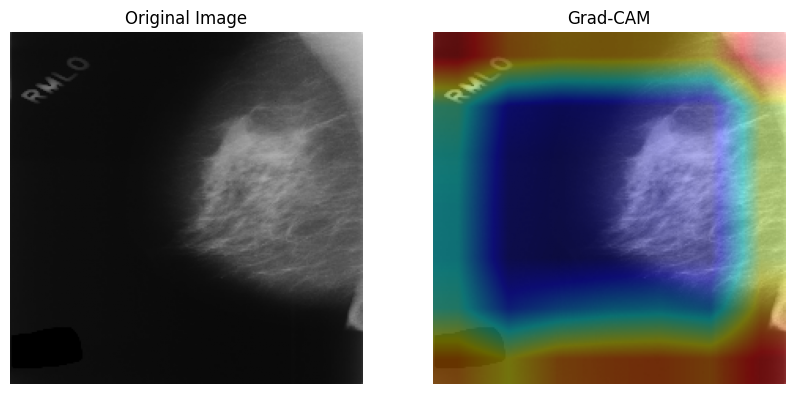

Accuracy: 0.5062, Precision: 0.5062, Recall: 1.0000, F1: 0.6721


In [3]:

# 5. Grad-CAM for Explainability
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activations)
        target_layer.register_backward_hook(self.save_gradients)

    def save_activations(self, module, input, output):
        self.activations = output

    def save_gradients(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def generate(self, input_image, class_idx=None):
        self.model.eval()
        input_image = input_image.to(device)
        output = self.model(input_image)
        if class_idx is None:
            class_idx = torch.argmax(output, dim=1).item()
        score = output[0, class_idx]
        self.model.zero_grad()
        score.backward()
        gradients = self.gradients.data
        activations = self.activations.data
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activations, dim=1, keepdim=True)
        cam = nn.functional.relu(cam)
        cam = cam - cam.min()
        cam = cam / cam.max()
        cam = cam.squeeze().cpu().numpy()
        return cam

def visualize_gradcam(model, image_path, target_layer):
    transform = data_transforms['test']
    # Read the image and check if it loaded successfully
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Failed to load image at {image_path}. Please check the path and file format.")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert NumPy array to PIL Image before applying transforms
    from PIL import Image
    image_pil = Image.fromarray(image)

    image_tensor = transform(image_pil).unsqueeze(0)
    grad_cam = GradCAM(model, target_layer)
    cam = grad_cam.generate(image_tensor)
    cam = cv2.resize(cam, (img_size, img_size))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    # Resize the original image (now a NumPy array) for display
    image_display = cv2.resize(image, (img_size, img_size)) / 255
    superimposed_img = heatmap * 0.4 + image_display # Use the resized NumPy array for superimposition
    superimposed_img = np.clip(superimposed_img, 0, 1)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image_display) # Display the resized NumPy array
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM")
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.show()

# Example usage of Grad-CAM
model.load_state_dict(torch.load('/content/drive/MyDrive/pretrained_model/best_model.pth'))
model.eval()
target_layer = model.layer4[-1].conv3  # Last convolutional layer in ResNet-50
visualize_gradcam(model, "/content/drive/MyDrive/Dataset/Test_set/Abnormal/C_0389_1.RIGHT_MLO.png", target_layer)

# 7. Evaluate Model
def evaluate_model(model, dataloader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

evaluate_model(model, dataloaders['test'])

  0%|          | 0/1000 [00:00<?, ?it/s]

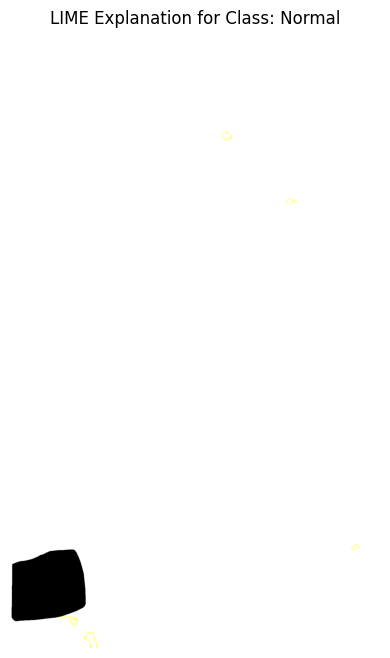

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model (same as your setup)
model = models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, len(class_names))  # Use num_classes from your dataset
)
model.load_state_dict(torch.load('/content/drive/MyDrive/pretrained_model/best_model.pth', map_location=device))
model = model.to(device)
model.eval()

# Define the test transform (same as your test dataset)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Function to preprocess image for LIME
def get_image(path):
    img = Image.open(path).convert('RGB')
    return img

# Function to convert image to tensor for model prediction
def get_input_tensors(img):
    transform = test_transform
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
    return img_tensor.to(device)

# Modified predict_proba function to handle batch of images
def predict_proba(images):
    # images: 4D numpy array [num_samples, height, width, channels]
    probs = []
    for image in images:
        # Convert single image (3D: [height, width, channels]) to PIL
        image = Image.fromarray(image.astype('uint8'), 'RGB')
        img_tensor = get_input_tensors(image)
        with torch.no_grad():
            outputs = model(img_tensor)
            prob = nn.functional.softmax(outputs, dim=1).cpu().numpy()
        probs.append(prob[0])  # Remove batch dimension from prob
    return np.array(probs)

# Load a test image (replace with actual path)
test_image_path = os.path.join(data_dir, 'Test_set', class_names[0], '/content/drive/MyDrive/Dataset/Test_set/Abnormal/C_0389_1.RIGHT_MLO.png')  # Update with actual path
img = get_image(test_image_path)

# Initialize LIME explainer
explainer = lime_image.LimeImageExplainer()

# Use a segmentation algorithm
segmentation_fn = SegmentationAlgorithm('quickshift', kernel_size=4, max_dist=200, ratio=0.2)

# Explain the prediction
explanation = explainer.explain_instance(
    np.array(img),
    predict_proba,
    top_labels=1,
    hide_color=0,
    num_samples=1000,
    segmentation_fn=segmentation_fn
)

# Visualize the explanation
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only=True,
    num_features=5,
    hide_rest=False
)

plt.figure(figsize=(8, 8))
plt.imshow(mark_boundaries(temp / 255.0, mask))
plt.title(f'LIME Explanation for Class: {class_names[explanation.top_labels[0]]}')
plt.axis('off')
plt.show()